In [1]:
#!/usr/bin/python
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.linear_model import RANSACRegressor
import scipy.stats
from matplotlib import style
from datetime import timedelta

import os
import matplotlib as mpl
%matplotlib inline
from scipy.stats import gamma, poisson
import epyestim
import epyestim.covid19 as covid19
from datetime import timedelta

plt.rcParams["font.family"] = "Palatino Linotype"
Net_df = pd.read_csv('Data/Net_df_1223_total_region.csv')

Net_df['inf_time'] = pd.to_datetime(Net_df['inf_time'], format="%Y-%m-%d", errors='ignore')
Net_df['inf_time'] = Net_df['inf_time'].dt.date
Net_df['Primary_id'] = Net_df['Primary_id'].astype(int)

Figure 1

c:\Users\bm990\Desktop\백업\Python_Code\Infection_Tree\.venv\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\bm990\Desktop\백업\Python_Code\Infection_Tree\.venv\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Gender And Weekly case spearman correlation
Corr : 0.4506, P-val : 0.0000
Corr : -0.4506, P-val : 0.0000
Gender And Weekly case pearson correlation
Corr : 0.2972, P-val : 0.0057
Corr : -0.2972, P-val : 0.0057


c:\Users\bm990\Desktop\백업\Python_Code\Infection_Tree\.venv\lib\site-packages\ipykernel_launcher.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator


1 Period
Corr : 0.7785, P-val : 0.0017
Corr : -0.5714, P-val : 0.0413
 
2 Period
Corr : 0.2000, P-val : 0.5554
Corr : 0.3364, P-val : 0.3118
 
3 Period
Corr : 0.7582, P-val : 0.0027
Corr : 0.2363, P-val : 0.4371
 
4 Period
Corr : 0.5070, P-val : 0.0267
Corr : 0.4982, P-val : 0.0299
 
5 Period
Corr : 0.5594, P-val : 0.0103
Corr : -0.2105, P-val : 0.3730
 
6 Period
Corr : -0.5500, P-val : 0.1250
Corr : 0.5667, P-val : 0.1116
 


c:\Users\bm990\Desktop\백업\Python_Code\Infection_Tree\.venv\lib\site-packages\ipykernel_launcher.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\Users\bm990\Desktop\백업\Python_Code\Infection_Tree\.venv\lib\site-packages\ipykernel_launcher.py:298: UserWarning: FixedFormatter should only be used together with FixedLocator


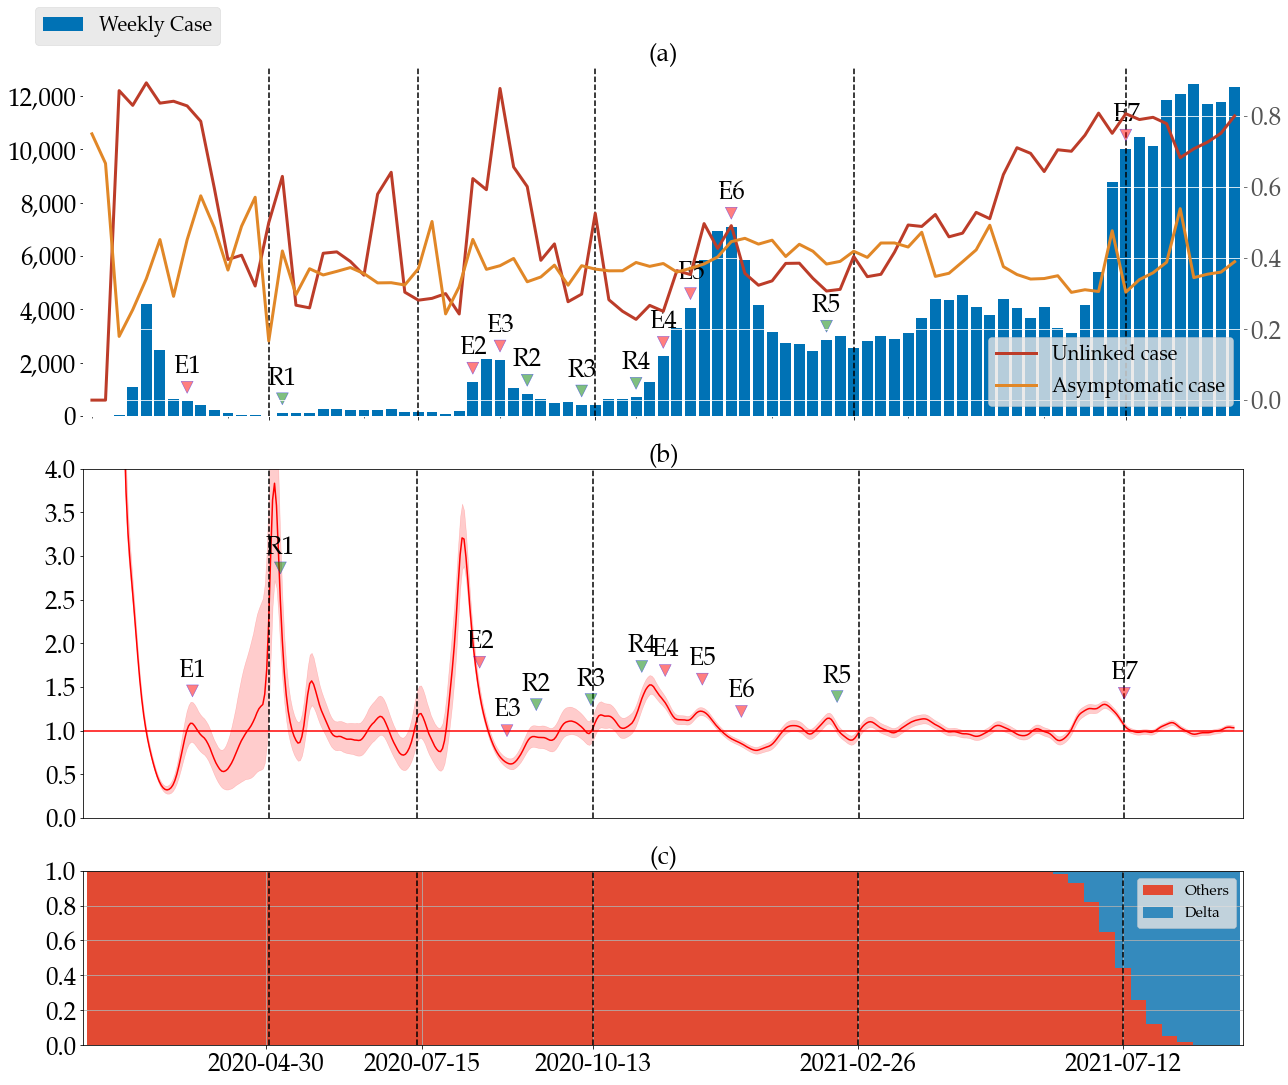

In [2]:
# fig = plt.figure(figsize=(18,15))#,constrained_layout=True)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(18, 15), gridspec_kw={'height_ratios': [2, 2, 1]})
# ax1 = plt.subplot(311)
# style.use('default')
style.use('ggplot')
# plt.style.use('seaborn-white')
plt.rcParams["font.family"] = "Palatino Linotype"

target_date = ['2020-01-19', '2021-09-16']
for i in range(len(target_date)):
    target_date[i] = datetime.strptime(target_date[i], "%Y-%m-%d").date()

for i in range(len(target_date) - 1):
    Net_df_1 = Net_df[(Net_df['inf_time'] >= target_date[i]) & (Net_df['inf_time'] < target_date[i + 1])]
    del Net_df_1['Unnamed: 0']

Net_df_3 = Net_df_1.copy()

Net_df_3['Count'] = 1
Net_df_3['Un_Count'] = 1
Net_df_3['Asym_Count'] = 1
Net_df_3['Un_Count'][Net_df_3['Primary_id'] != 0] = 0 #Primary_id가 0이 아닌거(Linked case)를 0으로 바꿔줌 -> Unknown이 1이 됨
Net_df_3['Asym_Count'][Net_df_3['Onset_date'] != '0'] = 0 #Onset_date가 0이 아닌거를 0으로 바꿔줌 -> Onset_date가 없는게 1이 됨

total_days = (list(Counter(Net_df_3['inf_time']))[-1] - list(Counter(Net_df_3['inf_time']))[0]).days
start_date = datetime.strptime('2020-01-30',"%Y-%m-%d").date()
week_date = []
Weekly_case = []
Asym_rate = []
Unknown_Primary_rate = []
Male_rate = []
Female_rate = []

plt.rcParams["font.family"] = "Palatino Linotype"
for i in range(int(np.floor(total_days/7)+1)): # Net_df_3의 길이는 날짜의 길이가 아님. 확진자의 정보임 -> 카운트를 한 후에 길이를 재야함.
    
    end_date = start_date + timedelta(days=7)
    
    R1_df3 = Net_df_3[['Count','Un_Count','Asym_Count']][(Net_df_3['inf_time']>= start_date) & (Net_df_3['inf_time']< end_date)]
    R_week_sum = R1_df3.sum()
    
    R1_df4 = Net_df_3['gender'][(Net_df_3['inf_time']>= start_date) & (Net_df_3['inf_time']< end_date)]
    R_gender_sum = R1_df4.sum()
    
    gender_count = dict(Counter(R_gender_sum))
    Male_rate.append(gender_count['남']/(gender_count['여'] + gender_count['남']))
    Female_rate.append(gender_count['여']/(gender_count['여'] + gender_count['남']))
    week_date.append(start_date)
    Weekly_case.append(R_week_sum[0])
    Unknown_Primary_rate.append((R_week_sum[1]/R_week_sum[0]))
    Asym_rate.append((R_week_sum[2]/R_week_sum[0]))
    
    start_date = end_date


r1, p1 = scipy.stats.spearmanr(Weekly_case,Male_rate)
r2, p2 = scipy.stats.spearmanr(Weekly_case,Female_rate)
print('Gender And Weekly case spearman correlation')
print('Corr : {0:.4f}, P-val : {1:.4f}'.format(r1,p1))
print('Corr : {0:.4f}, P-val : {1:.4f}'.format(r2,p2))


r1, p1 = scipy.stats.pearsonr(Weekly_case,Male_rate)
r2, p2 = scipy.stats.pearsonr(Weekly_case,Female_rate)
print('Gender And Weekly case pearson correlation')
print('Corr : {0:.4f}, P-val : {1:.4f}'.format(r1,p1))
print('Corr : {0:.4f}, P-val : {1:.4f}'.format(r2,p2))


plt.rcParams["font.family"] = "Palatino Linotype"    
# plt.figure(1)
R_week_df = pd.DataFrame({'date' : week_date,
                            'Weekly_case' : Weekly_case,
                            'Unknown_Primary_rate' : Unknown_Primary_rate,
                            'Asym_rate' : Asym_rate})

R_week_df.Weekly_case.plot(width=0.8, ax=ax1, kind="bar", color = '#0072B5FF', label = 'Weekly Case')
R_week_df.Unknown_Primary_rate.plot(secondary_y=True, color = '#BC3C29FF', linewidth = 3, ax=ax1, label='Unlinked case')
R_week_df.Asym_rate.plot(secondary_y=True, color = '#E18727FF', linewidth = 3,  ax=ax1, label = 'Asymptomatic case')
# yticks_ = ax1.get_yticks(minor=False)
plt.legend(['Unlinked case', 'Asymptomatic case'], loc = 'lower right', fontsize=20)
yticks_ = ax1.get_yticks(minor=False)
yticks_2 = []
for i2 in range(len(yticks_)):
    yticks_2.append(str(format(yticks_.astype(int)[i2], ',')))
ax1.set_yticklabels(yticks_2, fontsize=25)

# ax1.set_yticklabels(yticks_.astype(int), fontsize=25)
plt.yticks(fontsize=25)
# ax[0].set_yticks(fontsize=15)/
ax1.set_xticklabels(R_week_df['date'])
ax1.set_title('(a)',fontsize=25)
# ax1.set_xticklabels([datetime(2020, 4, 30).date(),datetime(2020, 7, 16).date(),datetime(2020, 10, 15).date(),datetime(2021, 2, 25).date(),datetime(2021, 7, 15).date()], fontsize=25, minor=False)
ax1.legend(loc = 'upper left',fontsize=20, bbox_to_anchor=(-0.05, 1.2))
ax1.axvline(x=13, color='k', linestyle='--')
ax1.axvline(x=24, color='k', linestyle='--')
ax1.axvline(x=37, color='k', linestyle='--')
ax1.axvline(x=56, color='k', linestyle='--')
ax1.axvline(x=76, color='k', linestyle='--')
ax1.xaxis.set_ticks([13,24,37,56,76])
ax1.xaxis.set_ticklabels([datetime(2020, 4, 30).date(),datetime(2020, 7, 16).date(),datetime(2020, 10, 15).date(),datetime(2021, 2, 25).date(),datetime(2021, 7, 15).date()], fontsize=25, minor=False)

# xticks_ = ax1.get_xticks(minor=False)
# ax1.set_xticks(xticks_)
# ax1.xaxis.remove()
Enarrow = { 'facecolor' : 'r', 
              'edgecolor':'b', 
              'shrink' : 1, 
              'alpha':0.5
              }

Rearrow = { 'facecolor' : 'g', 
              'edgecolor':'b', 
              'shrink' : 1, 
              'alpha':0.5
              }
fontsize_ = 25
arr_date_E = [7,28,30,42,44,47,76]
arr_date_R = [14,32,36,40,54]

for i2 in range(len(arr_date_E)):
    ax1.annotate('E' + str(i2+1), ha = 'center', va = 'bottom', fontsize=fontsize_,
    xytext = (arr_date_E[i2], R_week_df['Weekly_case'].loc[arr_date_E[i2]]+800),
    xy = (arr_date_E[i2], R_week_df['Weekly_case'].loc[arr_date_E[i2]]+300),
    arrowprops = Enarrow)

for i2 in range(len(arr_date_R)):
    ax1.annotate('R' + str(i2+1), ha = 'center', va = 'bottom', fontsize=fontsize_,
    xytext = (arr_date_R[i2], R_week_df['Weekly_case'].loc[arr_date_R[i2]]+800),
    xy = (arr_date_R[i2], R_week_df['Weekly_case'].loc[arr_date_R[i2]]+300),
    arrowprops = Rearrow)

# Calcuate P value and Correlation
rp_df = pd.DataFrame({})
division_line = [0,13,24,37,56,76,len(R_week_df)]
# division_line = [0,13,25,38,57,76,len(R_week_df)]
for i2 in range(len(division_line)-1):
    a = list(R_week_df['Unknown_Primary_rate'][division_line[i2]:division_line[i2+1]])
    b = list(R_week_df['Asym_rate'][division_line[i2]:division_line[i2+1]])
    c = list(R_week_df['Weekly_case'][division_line[i2]:division_line[i2+1]])
    # print(c)
    r1, p1 = scipy.stats.spearmanr(a,c)
    r2, p2 = scipy.stats.spearmanr(b,c)
    print(str(i2+1) + ' Period')
    print('Corr : {0:.4f}, P-val : {1:.4f}'.format(r1,p1))
    print('Corr : {0:.4f}, P-val : {1:.4f}'.format(r2,p2))
    print(' ')
    
#     rp_tmp = pd.DataFrame({'Unkonwn_r' : r1,
#                            'Unknown_p' : p1,
#                            'Asym_r' : [r2],
#                            'Asym_p' : [p2]})
#     rp_df = pd.concat([rp_df, rp_tmp])
# rp_df.to_csv('rp.csv',float_format = '%.4f', index=True)
# plt.show()


R_week_df.to_csv('Figure_1_data.csv')

##############
#EFFECTIVE RT#
##############

# ax2 = plt.subplot(312)

inf_date = list(Counter(Net_df['inf_time']).keys())
inf_val = list(Counter(Net_df['inf_time']).values())
Rt_df = pd.DataFrame({'Date' : inf_date, 'Confirmed cases' : inf_val})

plt.rcParams["font.family"] = "Palatino Linotype"
all_date_list = []
val_list = []
date_list = []
for i in range(527): # 527
    all_date_list.append(Rt_df['Date'][0] + timedelta(days=i))
    
    if Rt_df['Date'][0] + timedelta(days=i) not in inf_date:
        date_list.append(Rt_df['Date'][0] + timedelta(days=i))
        val_list.append(0)
Rt_df_2 = pd.DataFrame({'Date' : date_list,
                        'Confirmed cases': val_list})
Rt_df = pd.concat([Rt_df, Rt_df_2])
Rt_df = Rt_df.sort_values(['Date'])
Rt_df = Rt_df.set_index('Date')['Confirmed cases']

# plt.rcParams["font.family"] = "Palatino Linotype"
Rt_df_week = []
for i2 in range(0, len(Rt_df.index)):
    if i2 % 7 == 0:
        Rt_df_week.append(Rt_df.index[i2])
        
    else:
        Rt_df_week.append('')
# plt.rcParams["font.family"] = "Palatino Linotype"
##
ch_cases = Rt_df
si_distrb = covid19.generate_standard_si_distribution()
delay_distrb = covid19.generate_standard_infection_to_reporting_distribution()
ch_time_varying_r = covid19.r_covid(ch_cases)
                                    #,delay_distribution=bar_y
                                    #,gt_distribution=bar_y2)
# print(ch_time_varying_r)
plt.rcParams["font.family"] = "Palatino Linotype"
ch_time_varying_r.tail()
# print(ch_time_varying_r)
# plt.rcParams["font.family"] = "Palatino Linotype"
ax2.plot(ch_time_varying_r.loc[:,'Q0.5'], color='red')
ax2.fill_between(ch_time_varying_r.index, 
                    ch_time_varying_r['Q0.025'], 
                    ch_time_varying_r['Q0.975'], 
                    color='red', alpha=0.2)
ax2.set_title('(b)',fontsize=25)
plt.rcParams["font.family"] = "Palatino Linotype"
ax2.set_ylim([0,4])
ax2.axhline(y=1, color='r')
yticks_ = ax2.get_yticks(minor=False)
ax2.set_yticklabels(yticks_, fontsize=25)
ax2.set_xlim([datetime(2020, 1, 26), datetime(2021, 9, 11)])
ax2.axvline(x=datetime(2020, 4, 30), color='k', linestyle='--')
ax2.axvline(x=datetime(2020, 7, 15), color='k', linestyle='--')
ax2.axvline(x=datetime(2020, 10, 13), color='k', linestyle='--')
ax2.axvline(x=datetime(2021, 2, 26), color='k', linestyle='--')
ax2.axvline(x=datetime(2021, 7, 12), color='k', linestyle='--')
plt.rcParams["font.family"] = "Palatino Linotype"
ax2.xaxis.set_ticks([datetime(2020, 4, 30),
                    datetime(2020, 7, 15),
                    datetime(2020, 10, 13),
                    datetime(2021, 2, 26),
                    datetime(2021, 7, 12)])  
ax2.set_xticklabels([datetime(2020, 4, 30).date(),
                     datetime(2020, 7, 15).date(),
                     datetime(2020, 10, 13).date(),
                     datetime(2021, 2, 26).date(),
                     datetime(2021, 7, 12).date()], fontsize=25, minor=False, rotation=0)
ax2.axes.xaxis.set_visible(False)
Enarrow = { 'facecolor' : 'r', 
              'edgecolor':'b', 
              'shrink' : 1, 
              'alpha':0.5
              }

Rearrow = { 'facecolor' : 'g', 
              'edgecolor':'b', 
              'shrink' : 1, 
              'alpha':0.5
              }
fontsize_ = 25
arr_date_E = [datetime(2020, 3, 22),
            datetime(2020, 8, 16),
            datetime(2020, 8, 30),
            datetime(2020, 11, 19),
            datetime(2020, 12, 8),
            datetime(2020, 12, 28),
            datetime(2021, 7, 12)]

arr_date_R = [datetime(2020, 5, 6),
            datetime(2020, 9, 14),
            datetime(2020, 10, 12),
            datetime(2020, 11, 7),
            datetime(2021, 2, 15)]

for i2 in range(len(arr_date_E)):
    ax2.annotate('E' + str(i2+1), ha = 'center', va = 'bottom', fontsize=fontsize_,
    xytext = (arr_date_E[i2], ch_time_varying_r['R_mean'].loc[arr_date_E[i2].date()] + 0.45),
    xy = (arr_date_E[i2], ch_time_varying_r['R_mean'].loc[arr_date_E[i2].date()] + 0.3),
    arrowprops = Enarrow)
    
for i2 in range(len(arr_date_R)):
    ax2.annotate('R' + str(i2+1), ha = 'center', va = 'bottom', fontsize=fontsize_,
    xytext = (arr_date_R[i2], ch_time_varying_r['R_mean'].loc[arr_date_R[i2].date()] + 0.45),
    xy = (arr_date_R[i2], ch_time_varying_r['R_mean'].loc[arr_date_R[i2].date()] + 0.3),
    arrowprops = Rearrow)

ch_time_varying_r.to_csv('Figure_1_Rt.csv')

# ax3 = plt.subplot(313)
mutant_df = pd.read_csv('Data/Mutant.csv')
mutant_df = mutant_df.loc[2:75]

mutant_df[['Others', 'Delta']].plot.bar(stacked=True, ax=ax3, width=1)
ax3.set_xticklabels(mutant_df['Date'])
ax3.set_title('(c)', fontsize=25)

ax3.xaxis.set_ticks([11,21,32,49,66])
ax3.axvline(x=11.2, color='k', linestyle='--')
ax3.axvline(x=20.7, color='k', linestyle='--')
ax3.axvline(x=32, color='k', linestyle='--')
ax3.axvline(x=49, color='k', linestyle='--')
ax3.axvline(x=66, color='k', linestyle='--')
ax3.set_xticklabels([datetime(2020, 4, 30).date(),
                     datetime(2020, 7, 15).date(),
                     datetime(2020, 10, 13).date(),
                     datetime(2021, 2, 26).date(),
                     datetime(2021, 7, 12).date()], fontsize=25, minor=False, rotation=0)

yticks_ = ax3.get_yticks()
# ax3.set_yticks(yticks_, fontsize=25)
ax3.set_yticklabels(np.array(yticks_)/100, fontsize=25)
ax3.set_ylim([0, 100])
ax3.legend(fontsize=15)
# plt.yticks(fontsize=25)
# plt.ylim([0, 100])
fig.tight_layout()
fig.savefig('Estimate of time-varying effective reproduction number for Korea123')

# plt.show()


# Time Series of Unknown Primary and Asymptomatic per week

Timeseries of Age distribution

c:\Users\bm990\Desktop\백업\Python_Code\Infection_Tree\.venv\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\bm990\Desktop\백업\Python_Code\Infection_Tree\.venv\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\bm990\Desktop\백업\Python_Code\Infection_Tree\.venv\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<Figure size 432x288 with 0 Axes>

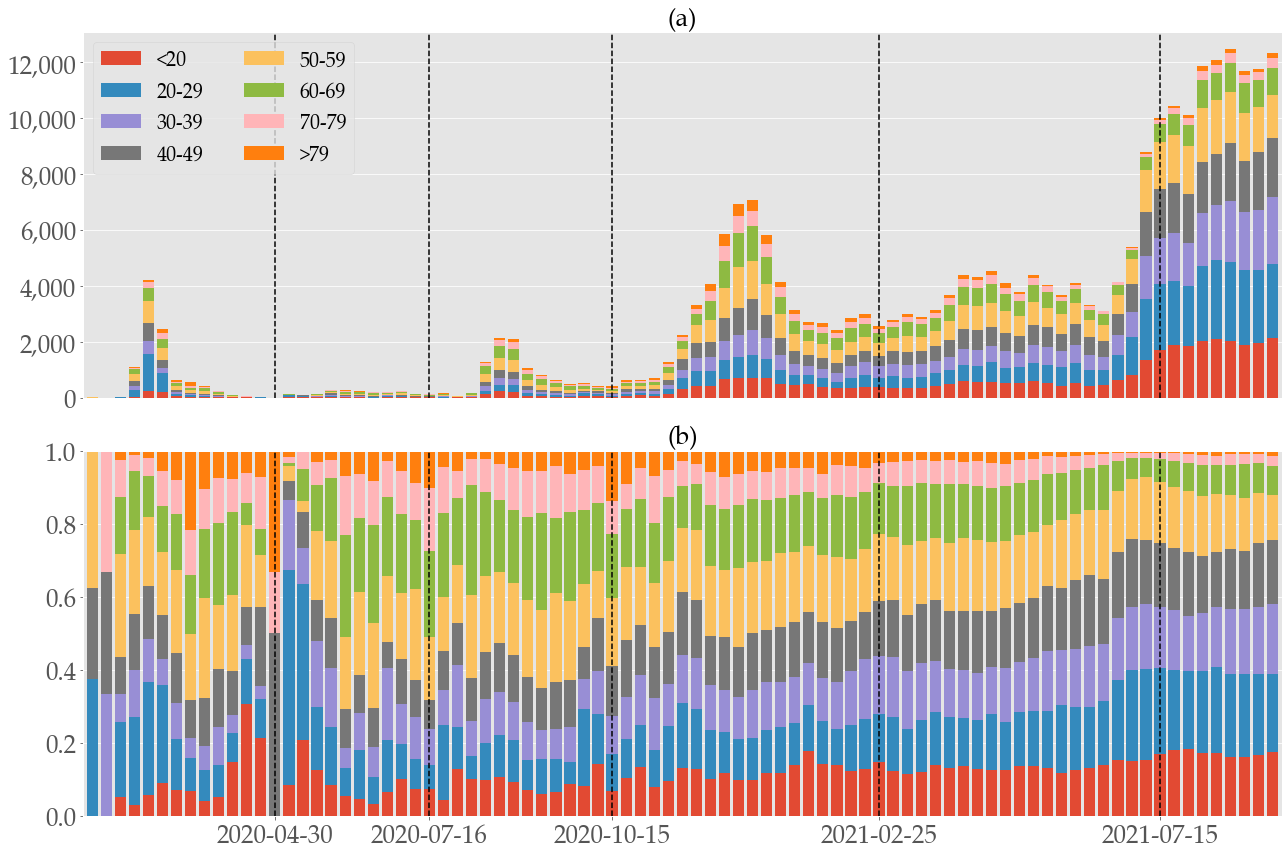

In [3]:
target_date = ['2020-01-19', '2021-09-16']
for i in range(len(target_date)):
    target_date[i] = datetime.strptime(target_date[i], "%Y-%m-%d").date()

for i in range(len(target_date) - 1):
    Net_df_1 = Net_df[(Net_df['inf_time'] >= target_date[i]) & (Net_df['inf_time'] < target_date[i + 1])]
    del Net_df_1['Unnamed: 0']
Net_df_2 = Net_df_1.copy()

Net_df_2['~20'] = 0
Net_df_2['2030'] = 0
Net_df_2['3040'] = 0
Net_df_2['4050'] = 0
Net_df_2['5060'] = 0
Net_df_2['6070'] = 0
Net_df_2['7080'] = 0
Net_df_2['80~'] = 0

Net_df_2['~20'][Net_df_2['age'] < 20] = 1
Net_df_2['2030'][(Net_df_2['age'] >= 20) & (Net_df_2['age'] < 30)] = 1
Net_df_2['3040'][(Net_df_2['age'] >= 30) & (Net_df_2['age'] < 40)] = 1
Net_df_2['4050'][(Net_df_2['age'] >= 40) & (Net_df_2['age'] < 50)] = 1
Net_df_2['5060'][(Net_df_2['age'] >= 50) & (Net_df_2['age'] < 60)] = 1
Net_df_2['6070'][(Net_df_2['age'] >= 60) & (Net_df_2['age'] < 70)] = 1
Net_df_2['7080'][(Net_df_2['age'] >= 70) & (Net_df_2['age'] < 80)] = 1
Net_df_2['80~'][Net_df_2['age'] >= 80] = 1

week_date = []
Weekly_case = []
Asym_rate = []
Unknown_Primary_rate = []
total_days = (list(Counter(Net_df_2['inf_time']))[-1] - list(Counter(Net_df_2['inf_time']))[0]).days
start_date = datetime.strptime('2020-01-30',"%Y-%m-%d").date()
W20 = []
W2030 = []
W3040 = []
W4050 = []
W5060 = []
W6070 = []
W7080 = []
W80 = []

for i in range(int(np.floor(total_days/7)+1)): # Net_df_3의 길이는 날짜의 길이가 아님. 확진자의 정보임 -> 카운트를 한 후에 길이를 재야함.
    
    end_date = start_date + timedelta(days=7)

    R1_df3 = Net_df_2[['~20','2030','3040','4050','5060','6070','7080','80~']][(Net_df_2['inf_time']>= start_date) & (Net_df_2['inf_time']< end_date)]
    R_week_sum = R1_df3.sum()
    
    week_date.append(start_date)
    W20.append(R_week_sum[0])
    W2030.append(R_week_sum[1])
    W3040.append(R_week_sum[2])
    W4050.append(R_week_sum[3])
    W5060.append(R_week_sum[4])
    W6070.append(R_week_sum[5])
    W7080.append(R_week_sum[6])
    W80.append(R_week_sum[7])
    
    start_date = end_date

plt.figure()
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(18,12))
style.use('ggplot')
R_week_df = pd.DataFrame({'date' : week_date,
                            '<20' : W20,
                            '20-29' : W2030,
                            '30-39' : W3040,
                            '40-49' : W4050,
                            '50-59' : W5060,
                            '60-69' : W6070,
                            '70-79' : W7080,
                            '>79' : W80})

#, '#bcbd22', '#17becf']
'#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'

R_week_df.plot.bar(ax=ax[0],width=0.8,stacked=True, color=['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8', '#ff7f0e'])

ax[0].axes.xaxis.set_visible(False)
xticks_ = ax[0].get_xticks(minor=False)
# yticks_ = ax[0].get_yticks(minor=False)
# yticks_ = [int(yt) for yt in yticks_]
ax[0].set_title('(a)', fontsize=25)
yticks_ = ax[0].get_yticks(minor=False)
yticks_2 = []
for i2 in range(len(yticks_)):
    yticks_2.append(str(format(yticks_.astype(int)[i2], ',')))
ax[0].set_yticklabels(yticks_2, fontsize=25)
# ax[0].set_yticklabels(yticks_, fontsize=25)
ax[0].axvline(x=13, color='k', linestyle='--')
ax[0].axvline(x=24, color='k', linestyle='--')
ax[0].axvline(x=37, color='k', linestyle='--')
ax[0].axvline(x=56, color='k', linestyle='--')
ax[0].axvline(x=76, color='k', linestyle='--')
ax[0].legend(loc='upper left', ncol=2, fontsize=20)

R_week_df_p = R_week_df.copy()
for idx in R_week_df.index:
    R_week_df_p.loc[idx,['<20', '20-29','30-39', '40-49', '50-59', '60-69', '70-79', '>79']] = R_week_df.loc[idx,['<20', '20-29','30-39', '40-49', '50-59', '60-69', '70-79', '>79']]/R_week_df.sum(axis=1)[idx]
    
R_week_df_p.plot.bar(ax=ax[1],width=0.8,stacked=True, color=['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8', '#ff7f0e'])
xticks_ = ax[1].get_xticks(minor=False)
ax[1].xaxis.set_ticks([13,24,37,56,76])
ax[1].set_xticklabels([datetime(2020, 4, 30).date(),datetime(2020, 7, 16).date(),datetime(2020, 10, 15).date(),datetime(2021, 2, 25).date(),datetime(2021, 7, 15).date()], rotation = 0, fontsize=25, minor=False)
plt.yticks(fontsize=25)
ax[1].set_title('(b)', fontsize=25)
ax[1].axvline(x=13, color='k', linestyle='--')
ax[1].axvline(x=24, color='k', linestyle='--')
ax[1].axvline(x=37, color='k', linestyle='--')
ax[1].axvline(x=56, color='k', linestyle='--')
ax[1].axvline(x=76, color='k', linestyle='--')
ax[1].set_ylim([0, 1])
ax[1].get_legend().set_visible(False)

plt.tight_layout()
# plt.show()
plt.savefig('Age distribution Timeseries per week')

FIGURE 6

c:\Users\bm990\Desktop\백업\Python_Code\Infection_Tree\.venv\lib\site-packages\ipykernel_launcher.py:113: UserWarning: FixedFormatter should only be used together with FixedLocator


Family : 0.010
Colleagues : 0.009
Friends : 0.052
Etc : 0.027
Unknown : 0.901
 
Family : 0.172
Colleagues : 0.150
Friends : 0.159
Etc : 0.133
Unknown : 0.386
 
Family : 0.050
Colleagues : 0.047
Friends : 0.107
Etc : 0.036
Unknown : 0.760
 
Family : 0.085
Colleagues : 0.092
Friends : 0.277
Etc : 0.207
Unknown : 0.339
 
Family : 0.084
Colleagues : 0.078
Friends : 0.187
Etc : 0.110
Unknown : 0.540
 
Family : 0.064
Colleagues : 0.052
Friends : 0.111
Etc : 0.093
Unknown : 0.679
 


<Figure size 432x288 with 0 Axes>

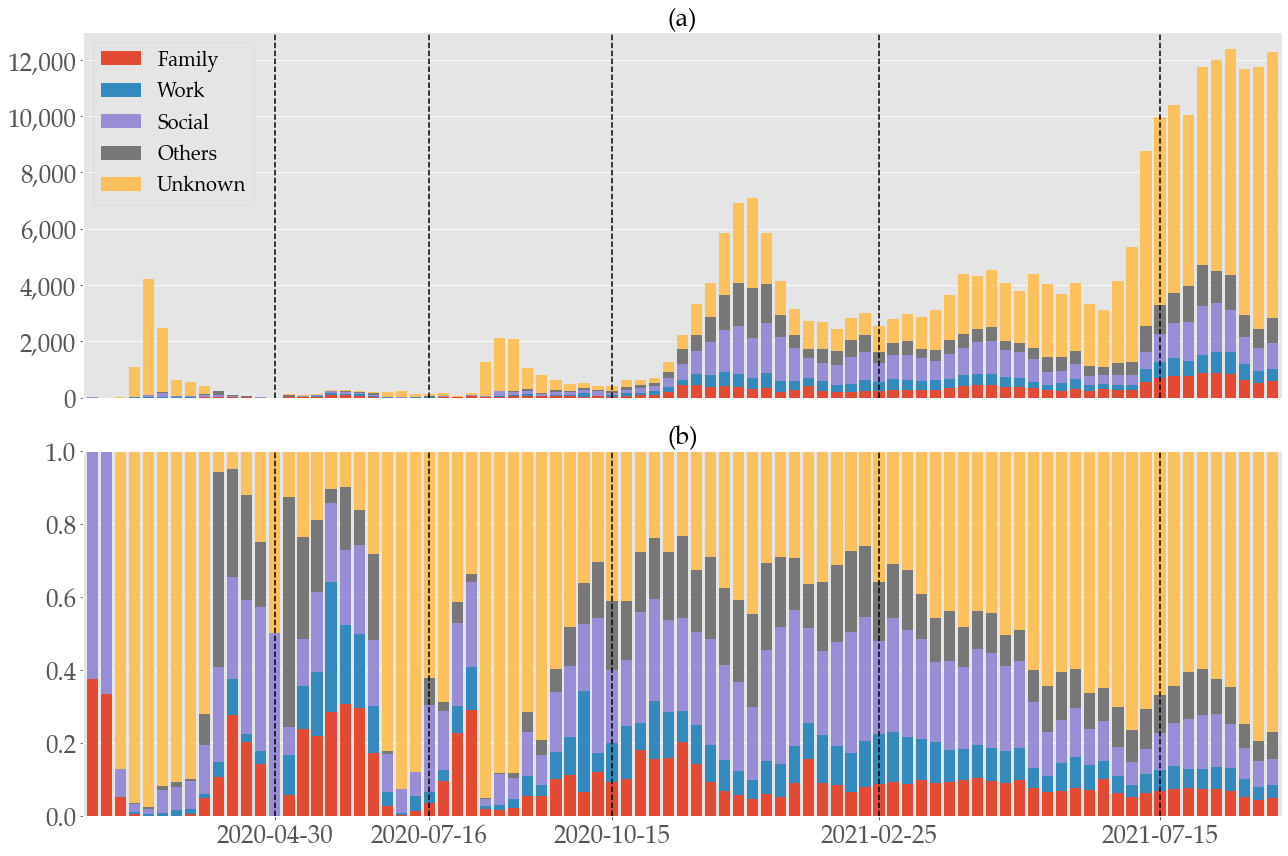

In [4]:
# ########################
# FIGURE 6
# Delay and Relation
# ########################

style.use('ggplot')
target_date = ['2020-01-19', '2021-09-16']

for i in range(len(target_date)):
    target_date[i] = datetime.strptime(target_date[i], "%Y-%m-%d").date()

for i in range(len(target_date) - 1):
    Net_df_1 = Net_df.loc[:][(Net_df.loc[:,'inf_time'] >= target_date[i]) & (Net_df.loc[:,'inf_time'] < target_date[i + 1])]

R1 = ['지인','친구','친척']
R2 = ['동료','직장','직장동료','직원','업무','업무-가족','업무관련','고객']
R3 = ['가족','아들','동일가구']
R4 = ['동일병동','의료기관종사자','의료진','의료진-간병인','환자','간병인','동일병원','수간호사',
      '학생','학원생','수학과외교사','원생',
      '동일장소','동일시설','동일업소방문','동일업소이용','동일항공기',
      '요양원입소자', '입소자','접촉자','손님','신천지지인', '방문자',
      '종사자','이용자','기타']
R5 = ['조사중','확인중','지표','0']


R_date = [[],[],[],[],[]]
date_inf = [[],[],[],[],[]]
val_inf = [[],[],[],[],[]]

for i2 in Net_df_1.index:

    if Net_df_1.loc[i2, 'Primary_relation'] in R1:
        R_date[0].append(Net_df_1.loc[i2, 'inf_time'])

    elif Net_df_1.loc[i2, 'Primary_relation'] in R2:
        R_date[1].append(Net_df_1.loc[i2, 'inf_time'])

    elif Net_df_1.loc[i2, 'Primary_relation'] in R3:
        R_date[2].append(Net_df_1.loc[i2, 'inf_time'])

    elif Net_df_1.loc[i2, 'Primary_relation'] in R4:
        R_date[3].append(Net_df_1.loc[i2, 'inf_time'])
        
    elif Net_df_1.loc[i2, 'Primary_relation'] in R5:
        R_date[4].append(Net_df_1.loc[i2, 'inf_time'])
        
        
R_title = ['Family', 'Colleagues, Work-related', 'Acquaintance, Friend', 'Etc','Unknown']
R_color = ['royalblue','goldenrod','firebrick','pink','yellow']
R_bottom = [np.array([0]),np.array(val_inf[1]),np.array(val_inf[1])+np.array(val_inf[2]),np.array(val_inf[1])+np.array(val_inf[2])+np.array(val_inf[3])]
R1_df = pd.DataFrame.from_dict(dict(Counter(R_date[0])),orient='index',columns=[R_title[0]])
for i2 in range(4):
    R1_df = pd.concat([R1_df,pd.DataFrame.from_dict(dict(Counter(R_date[i2+1])),orient='index',columns=[R_title[i2+1]])], axis=1)
R1_df = R1_df.sort_index()
R1_df['index'] = [i2 for i2 in range(len(R1_df))]
R_date = R1_df.index
R1_df2 = R1_df.set_index('index')
R1_df2['R_date'] = R_date


style.use('ggplot')
start_date = datetime.strptime('2020-01-30',"%Y-%m-%d").date()
week_date = []
week_R1 = []
week_R2 = []
week_R3 = []
week_R4 = []
week_un = []
for i in range(int(np.floor(len(R1_df)/7)+3)):
    
    end_date = start_date + timedelta(days=7)
    
    R1_df3 = R1_df2[(R1_df2['R_date']>= start_date) & (R1_df2['R_date']< end_date)]
    # R1_df3.replace(np.nan, 0)
    R_week_sum = R1_df3.sum()
    
    week_date.append(start_date)
    week_R1.append(R_week_sum[0])
    week_R2.append(R_week_sum[1])
    week_R3.append(R_week_sum[2])
    week_R4.append(R_week_sum[3])
    week_un.append(R_week_sum[4])
    
    start_date = end_date

plt.figure()
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(18,12))
R_week_df = pd.DataFrame({'date' : week_date,
                            'Family' : week_R1,
                            'Work' : week_R2, 
                            'Social' : week_R3, 
                            'Others' : week_R4,
                            'Unknown' : week_un})


R_week_df.plot.bar(width=0.8,stacked=True, ax=ax[0])#,xticks=[day*14 for day in range(int(np.floor(len(R1_df)/14)))])
# ax.bar(stacked=True,xticks=[day*14 for day in range(int(np.floor(len(R1_df)/14)))])
# ax.set_xticklabels(R_week_df['date'])
# xticks_ = ax[0].get_xticks(minor=False)
# ax[0].set_xticks(xticks_, color='w')
ax[0].axes.xaxis.set_visible(False)
# ax[0].xaxis.set_ticks([13,24,37,56,76])
# ax[0].set_xticklabels([datetime(2020, 4, 30).date(),datetime(2020, 7, 16).date(),datetime(2020, 10, 15).date(),datetime(2021, 2, 25).date(),datetime(2021, 7, 15).date()], rotation = 0, fontsize=25, minor=False)
# ax[0].set_xticklabels(rotation = 0, fontsize=25, minor=False)

# plt.title('Stacked bar chart of primary relation',fontsize=15)
# yticks_ = ax[0].get_yticks(minor=False)
# yticks_ = [int(yt) for yt in yticks_]
yticks_ = ax[0].get_yticks(minor=False)
yticks_2 = []
for i2 in range(len(yticks_)):
    yticks_2.append(str(format(yticks_.astype(int)[i2], ',')))
ax[0].set_yticklabels(yticks_2, fontsize=25)
# ax[0].set_yticklabels(yticks_, fontsize=25)
ax[0].set_title('(a)', fontsize=25)
ax[0].axvline(x=13, color='k', linestyle='--')
ax[0].axvline(x=24, color='k', linestyle='--')
ax[0].axvline(x=37, color='k', linestyle='--')
ax[0].axvline(x=56, color='k', linestyle='--')
ax[0].axvline(x=76, color='k', linestyle='--')
ax[0].legend(loc='upper left', fontsize=20)
# print(yticks_)
R_week_df_p = R_week_df.copy()
for idx in R_week_df.index:
    R_week_df_p.loc[idx,['Family', 'Work','Social', 'Others', 'Unknown']] = R_week_df.loc[idx,['Family', 'Work','Social', 'Others', 'Unknown']]/R_week_df.sum(axis=1)[idx]
    
R_week_df_p.plot.bar(width=0.8,stacked=True, ax=ax[1])
xticks_ = ax[1].get_xticks(minor=False)
ax[1].xaxis.set_ticks([13,24,37,56,76])
ax[1].set_xticklabels([datetime(2020, 4, 30).date(),datetime(2020, 7, 16).date(),datetime(2020, 10, 15).date(),datetime(2021, 2, 25).date(),datetime(2021, 7, 15).date()], rotation = 0, fontsize=25, minor=False)
plt.yticks(fontsize=25)
ax[1].set_title('(b)', fontsize=25)
ax[1].axvline(x=13, color='k', linestyle='--')
ax[1].axvline(x=24, color='k', linestyle='--')
ax[1].axvline(x=37, color='k', linestyle='--')
ax[1].axvline(x=56, color='k', linestyle='--')
ax[1].axvline(x=76, color='k', linestyle='--')
ax[1].get_legend().set_visible(False)
ax[1].set_ylim([0, 1])
# plt.legend(loc='upper left', fontsize=20)

plt.tight_layout()
plt.savefig('Relation Timeseries per week.png')


R_week_sum = sum(R_week_df.iloc[0:13].sum())
R_week_list = [R_week_df.iloc[0:13].sum()[i2]/R_week_sum for i2 in range(len(R_week_df.sum()))]
print('Family : {0:.3f}'.format(R_week_list[0]))
print('Colleagues : {0:.3f}'.format(R_week_list[1]))
print('Friends : {0:.3f}'.format(R_week_list[2]))
print('Etc : {0:.3f}'.format(R_week_list[3]))
print('Unknown : {0:.3f}'.format(R_week_list[4]))
print(' ')

R_week_sum = sum(R_week_df.iloc[14:24].sum())
R_week_list = [R_week_df.iloc[14:24].sum()[i2]/R_week_sum for i2 in range(len(R_week_df.sum()))]
print('Family : {0:.3f}'.format(R_week_list[0]))
print('Colleagues : {0:.3f}'.format(R_week_list[1]))
print('Friends : {0:.3f}'.format(R_week_list[2]))
print('Etc : {0:.3f}'.format(R_week_list[3]))
print('Unknown : {0:.3f}'.format(R_week_list[4]))
print(' ')

R_week_sum = sum(R_week_df.iloc[25:37].sum())
R_week_list = [R_week_df.iloc[25:37].sum()[i2]/R_week_sum for i2 in range(len(R_week_df.sum()))]
print('Family : {0:.3f}'.format(R_week_list[0]))
print('Colleagues : {0:.3f}'.format(R_week_list[1]))
print('Friends : {0:.3f}'.format(R_week_list[2]))
print('Etc : {0:.3f}'.format(R_week_list[3]))
print('Unknown : {0:.3f}'.format(R_week_list[4]))
print(' ')

R_week_sum = sum(R_week_df.iloc[38:56].sum())
R_week_list = [R_week_df.iloc[38:56].sum()[i2]/R_week_sum for i2 in range(len(R_week_df.sum()))]
print('Family : {0:.3f}'.format(R_week_list[0]))
print('Colleagues : {0:.3f}'.format(R_week_list[1]))
print('Friends : {0:.3f}'.format(R_week_list[2]))
print('Etc : {0:.3f}'.format(R_week_list[3]))
print('Unknown : {0:.3f}'.format(R_week_list[4]))
print(' ')

R_week_sum = sum(R_week_df.iloc[57:75].sum())
R_week_list = [R_week_df.iloc[57:75].sum()[i2]/R_week_sum for i2 in range(len(R_week_df.sum()))]
print('Family : {0:.3f}'.format(R_week_list[0]))
print('Colleagues : {0:.3f}'.format(R_week_list[1]))
print('Friends : {0:.3f}'.format(R_week_list[2]))
print('Etc : {0:.3f}'.format(R_week_list[3]))
print('Unknown : {0:.3f}'.format(R_week_list[4]))
print(' ')

R_week_sum = sum(R_week_df.iloc[76:].sum())
R_week_list = [R_week_df.iloc[76:].sum()[i2]/R_week_sum for i2 in range(len(R_week_df.sum()))]
print('Family : {0:.3f}'.format(R_week_list[0]))
print('Colleagues : {0:.3f}'.format(R_week_list[1]))
print('Friends : {0:.3f}'.format(R_week_list[2]))
print('Etc : {0:.3f}'.format(R_week_list[3]))
print('Unknown : {0:.3f}'.format(R_week_list[4]))
print(' ')
